***MODELO NEGOCIOS PROMEDIO***

In [18]:
import pandas as pd

# 1. Cargar el archivo
# Asegúrate de que el archivo 'cuadrantes_negocios.csv' esté en la misma carpeta del script
file_path = "cuadrantes_negocios.csv"
df_original = pd.read_csv(file_path)

# Renombrar las columnas de los meses para facilitar la manipulación
meses = [f'M{i}' for i in range(1, 13)]
df_original.columns = ['CUADRANTE', 'POBLACION'] + meses

# 2. Configuración de los Lags (Meses Anteriores)
# Definimos cuántos meses anteriores (lags) queremos usar como variables de entrada (X)
# Usaremos M-1 y M-2, y el Lag Estacional M-12
LAGS = [1, 2] # Lags inmediatos

# 3. Preparación de la Matriz de Entrenamiento (X y Y)
datos_entrenamiento = []

# Iterar sobre cada uno de los 78 cuadrantes
for index, row in df_original.iterrows():
    cuadrante = row['CUADRANTE']
    poblacion = row['POBLACION']
    
    # El valor del Lag Estacional (M-12) será el mismo para todas las filas de este cuadrante
    # En tu caso, es el promedio de robos del Mes 12
    robo_m12_estacional = row['M12'] 
    
    # Iterar desde el Mes 3 hasta el Mes 12 para crear las filas de entrenamiento
    # No podemos predecir el Mes 1 y Mes 2 porque no tenemos M0, M-1, etc.
    for mes_a_predecir in range(3, 13):
        
        # Variable de Salida (Y): El promedio de robos del mes actual (M)
        mes_actual_col = f'M{mes_a_predecir}'
        Y_robo = row[mes_actual_col]
        
        # Variables de Entrada (Lags): Robos de los meses anteriores
        X_lags = {}
        
        for lag in LAGS:
            mes_anterior = mes_a_predecir - lag
            mes_anterior_col = f'M{mes_anterior}'
            
            # Obtener el valor del lag: PROMEDIO DE ROBOS MES M-N
            X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
        
        # Construir la fila de datos
        fila_datos = {
            'CUADRANTE': cuadrante,
            'POBLACION': poblacion,
            'MES A PREDECIR (M)': mes_a_predecir,
            'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
            'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
            'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
            'PROMEDIO DE ROBOS (Y)': Y_robo
        }
        
        datos_entrenamiento.append(fila_datos)

# Crear el DataFrame final de entrenamiento
df_entrenamiento = pd.DataFrame(datos_entrenamiento)

# 4. Mostrar las primeras filas (ejemplo)
print("✅ Estructura del DataFrame de Entrenamiento (Primeras Filas):")
print(df_entrenamiento.head())

# 5. Información del DataFrame
print("\nℹ Dimensiones del DataFrame:")
# Debes tener 78 cuadrantes * 10 meses de predicción (M3 a M12) = 780 filas
print(f"Filas: {len(df_entrenamiento)}, Columnas: {len(df_entrenamiento.columns)}")

✅ Estructura del DataFrame de Entrenamiento (Primeras Filas):
   CUADRANTE  POBLACION  MES A PREDECIR (M)  ROBOS MES M-1  ROBOS MES M-2  \
0        1.0        0.0                   3            0.2            0.2   
1        1.0        0.0                   4            0.1            0.2   
2        1.0        0.0                   5            0.5            0.1   
3        1.0        0.0                   6            0.0            0.5   
4        1.0        0.0                   7            0.4            0.0   

   ROBOS MES M-12 (Estacional)  PROMEDIO DE ROBOS (Y)  
0                          0.1                    0.1  
1                          0.1                    0.5  
2                          0.1                    0.0  
3                          0.1                    0.4  
4                          0.1                    0.1  

ℹ Dimensiones del DataFrame:
Filas: 780, Columnas: 7


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- Bloque 1: Transformación de Datos (Copiar del código anterior) ---

# Cargar el archivo
file_path = "cuadrantes_negocios.csv"
df_original = pd.read_csv(file_path)

# Renombrar columnas
meses = [f'M{i}' for i in range(1, 13)]
df_original.columns = ['CUADRANTE', 'POBLACION'] + meses

LAGS = [1, 2] 
datos_entrenamiento = []

for index, row in df_original.iterrows():
    cuadrante = row['CUADRANTE']
    poblacion = row['POBLACION']
    robo_m12_estacional = row['M12'] 
    
    # Iterar del Mes 3 al Mes 12
    for mes_a_predecir in range(3, 13):
        
        mes_actual_col = f'M{mes_a_predecir}'
        Y_robo = row[mes_actual_col]
        
        X_lags = {}
        for lag in LAGS:
            mes_anterior_col = f'M{mes_a_predecir - lag}'
            X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
        
        fila_datos = {
            'CUADRANTE': cuadrante,
            'POBLACION': poblacion,
            'MES A PREDECIR (M)': mes_a_predecir,
            'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
            'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
            'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
            'PROMEDIO DE ROBOS (Y)': Y_robo
        }
        
        datos_entrenamiento.append(fila_datos)

df_entrenamiento = pd.DataFrame(datos_entrenamiento)
# -----------------------------------------------------------------------


# --- Bloque 2: Preparación y División de Datos ---

print("\n## 1. Preparando Datos para el Modelo ⚙️")

# 1. Definir las Variables Predictoras (X) y la Variable Objetivo (Y)
# Excluimos 'CUADRANTE' porque queremos que el modelo aprenda patrones de todos los cuadrantes
# En lugar de solo memorizar qué promedio tiene cada uno.

features = [
    'POBLACION', 
    'MES A PREDECIR (M)', 
    'ROBOS MES M-1', 
    'ROBOS MES M-2',
    'ROBOS MES M-12 (Estacional)'
]

X = df_entrenamiento[features]
Y = df_entrenamiento['PROMEDIO DE ROBOS (Y)']

# 2. División de los datos en Entrenamiento (80%) y Prueba (20%)
# El 'random_state' asegura que siempre obtengas los mismos resultados.
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42
)

print(f"Tamaño de X_train (Entrenamiento): {X_train.shape}")
print(f"Tamaño de X_test (Prueba): {X_test.shape}")


# --- Bloque 3: Entrenamiento del Modelo Random Forest ---

print("\n## 2. Entrenamiento del Random Forest Regressor 🌲")

# Inicializar el modelo
# n_estimators: Número de árboles en el bosque (más árboles = más precisión, más tiempo)
rf_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1 # Usa todos los núcleos del procesador
)

# Entrenar el modelo
rf_model.fit(X_train, Y_train)

print("Modelo Random Forest entrenado exitosamente.")


# --- Bloque 4: Predicción y Evaluación del Modelo ---

print("\n## 3. Predicción y Evaluación del Modelo 📊")

# Realizar predicciones sobre el conjunto de prueba (X_test)
Y_pred = rf_model.predict(X_test)

# Calcular métricas de rendimiento

# 1. Error Cuadrático Medio (RMSE)
# Es el promedio de los errores al cuadrado. Un valor más bajo es mejor.
# Utilizamos RMSE (Root Mean Squared Error) porque está en las mismas unidades que Y.
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

# 2. Coeficiente de Determinación (R²)
# Mide qué tan bien se ajustan los datos al modelo. Un valor más cercano a 1.0 es mejor.
r2 = r2_score(Y_test, Y_pred)

print(f"➡️ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"➡️ Coeficiente de Determinación (R²): {r2:.4f}")

# 3. Importancia de las Características
# Esto te ayuda a saber qué variables influyen más en la predicción.
importancias = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

print("\n⭐ Importancia de las Características (Features):")
print(importancias)


## 1. Preparando Datos para el Modelo ⚙️
Tamaño de X_train (Entrenamiento): (624, 5)
Tamaño de X_test (Prueba): (156, 5)

## 2. Entrenamiento del Random Forest Regressor 🌲
Modelo Random Forest entrenado exitosamente.

## 3. Predicción y Evaluación del Modelo 📊
➡️ Root Mean Squared Error (RMSE): 0.4919
➡️ Coeficiente de Determinación (R²): 0.8516

⭐ Importancia de las Características (Features):
ROBOS MES M-12 (Estacional)    0.711513
ROBOS MES M-1                  0.146871
ROBOS MES M-2                  0.087386
MES A PREDECIR (M)             0.028248
POBLACION                      0.025982
dtype: float64


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") # Ignorar warnings para una salida más limpia


# ----------------------------------------------------------------------
# FUNCIONES DE PREPARACIÓN Y ENTRENAMIENTO
# ----------------------------------------------------------------------

def preparar_y_entrenar_modelo(file_path):
    """Carga, transforma y entrena el modelo Random Forest."""
    print("Iniciando preparación de datos...")
    
    df_original = pd.read_csv(file_path)
    # Renombrar columnas para usar M1, M2, etc.
    meses_cols = [f'M{i}' for i in range(1, 13)]
    df_original.columns = ['CUADRANTE', 'POBLACION'] + meses_cols
    
    LAGS = [1, 2] 
    datos_entrenamiento = []

    # Crear la matriz de entrenamiento
    for index, row in df_original.iterrows():
        cuadrante = row['CUADRANTE']
        poblacion = row['POBLACION']
        # El Lag Estacional M-12 es el promedio del Mes 12
        robo_m12_estacional = row['M12'] 
        
        # Iterar del Mes 3 al Mes 12
        for mes_a_predecir in range(3, 13):
            Y_robo = row[f'M{mes_a_predecir}']
            X_lags = {}
            for lag in LAGS:
                mes_anterior_col = f'M{mes_a_predecir - lag}'
                X_lags[f'ROBOS MES M-{lag}'] = row[mes_anterior_col]
            
            fila_datos = {
                'CUADRANTE': cuadrante,
                'POBLACION': poblacion,
                'MES A PREDECIR (M)': mes_a_predecir,
                'ROBOS MES M-1': X_lags.get('ROBOS MES M-1'),
                'ROBOS MES M-2': X_lags.get('ROBOS MES M-2'),
                'ROBOS MES M-12 (Estacional)': robo_m12_estacional,
                'PROMEDIO DE ROBOS (Y)': Y_robo
            }
            datos_entrenamiento.append(fila_datos)

    df_entrenamiento = pd.DataFrame(datos_entrenamiento)
    
    # 1. Definir Features (X) y Target (Y)
    features = [
        'POBLACION', 
        'MES A PREDECIR (M)', 
        'ROBOS MES M-1', 
        'ROBOS MES M-2',
        'ROBOS MES M-12 (Estacional)'
    ]
    X = df_entrenamiento[features]
    Y = df_entrenamiento['PROMEDIO DE ROBOS (Y)']

    # 2. División de los datos
    X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.2, random_state=42)

    # 3. Entrenamiento del Modelo
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, Y_train)
    
    print("✅ Modelo entrenado exitosamente.")
    
    return rf_model, df_original


# ----------------------------------------------------------------------
# FUNCIONES DE PREDICCIÓN (ROLLING FORECAST)
# ----------------------------------------------------------------------

def predict_future_months(rf_model, df_original, total_months_to_predict, start_year=2024):
    """
    Realiza un pronóstico rodante (Rolling Forecast) para N meses futuros.
    Utiliza las predicciones como input para la siguiente predicción.
    """
    # Obtener los últimos datos conocidos (M11 y M12 del archivo original)
    data_known = df_original[['CUADRANTE', 'POBLACION', 'M11', 'M12']].copy()
    data_known.rename(columns={'M11': 'ROBOS MES M-2', 'M12': 'ROBOS MES M-1'}, inplace=True)
    
    # Usar M12 como el Lag Estacional para el pronóstico
    data_known['ROBOS MES M-12 (Estacional)'] = df_original['M12'] 

    forecast_results = {}
    current_mes = 1 # El Mes 13 es Enero (Mes 1 del nuevo ciclo)
    current_year = start_year
    
    print(f"\nIniciando Pronóstico Rodante para {total_months_to_predict} meses...")

    for i in range(1, total_months_to_predict + 1):
        
        # 1. Preparar el DataFrame de entrada (X)
        X_predict = data_known[['POBLACION', 'ROBOS MES M-1', 'ROBOS MES M-2', 'ROBOS MES M-12 (Estacional)']].copy()
        X_predict['MES A PREDECIR (M)'] = current_mes 
        
        features_order = ['POBLACION', 'MES A PREDECIR (M)', 'ROBOS MES M-1', 'ROBOS MES M-2', 'ROBOS MES M-12 (Estacional)']
        X_predict = X_predict[features_order]
        
        # 2. Realizar la Predicción
        predictions = rf_model.predict(X_predict)
        
        # 3. Guardar los resultados del mes actual
        mes_str = datetime(current_year, current_mes, 1).strftime('%Y-%m')
        
        df_pred = pd.DataFrame({
            'CUADRANTE': data_known['CUADRANTE'], 
            'PREDICCION': predictions,
            'FECHA': mes_str
        })
        forecast_results[mes_str] = df_pred
        
        # 4. Actualizar los Lags (Rolling Forecast)
        data_known['ROBOS MES M-2'] = data_known['ROBOS MES M-1'] # M-1 se convierte en M-2
        data_known['ROBOS MES M-1'] = predictions               # Predicción se convierte en M-1
        
        # Actualizar el mes y año para la siguiente iteración
        current_mes += 1
        if current_mes > 12:
            current_mes = 1
            current_year += 1

    return pd.concat(forecast_results.values(), ignore_index=True)

def mostrar_top_incidencias(df_forecast, target_month, top_n=5):
    """Filtra y muestra el top N de cuadrantes con más robos en un mes específico."""
    
    mes_target = target_month

    df_mes = df_forecast[df_forecast['FECHA'] == mes_target].copy()
    
    if df_mes.empty:
        print(f"\n❌ Error: No se encontró el mes {mes_target} en el pronóstico.")
        return
        
    df_top = df_mes.sort_values(by='PREDICCION', ascending=False).head(top_n)
    
    print(f"\n⭐ TOP {top_n} CUADRANTES CON MAYOR INCIDENCIA PREDECIDA en {mes_target}:")
    print("---------------------------------------------------------")
    
    df_top['PREDICCION'] = df_top['PREDICCION'].round(2)
    
    print(df_top[['CUADRANTE', 'PREDICCION']].to_markdown(index=False))


# ----------------------------------------------------------------------
## ----------------------------------------------------------------------
# EJECUCIÓN PRINCIPAL DEL PROGRAMA
# ----------------------------------------------------------------------

# 1. Definir la ruta del archivo
file_path = "cuadrantes_negocios.csv"

# 2. Entrenar el modelo
rf_model, df_original = preparar_y_entrenar_modelo(file_path)

# --- CONFIGURACIÓN DE PREDICCIÓN PARA AÑOS FUTUROS ---

# 3. Definir cuántos meses hacia adelante quieres predecir
# Para llegar del final de tus datos (asumimos 2023) hasta el final de 2026:
# 2024 (12 meses) + 2025 (12 meses) + 2026 (12 meses) = 36 meses
TOTAL_MESES_A_PREDECIR = 36 

# 4. Establecer el primer año que desea predecir (Enero del 2024)
AÑO_INICIAL_PREDICCION = 2024

# 5. Generar el Pronóstico Rodante
df_forecast = predict_future_months(
    rf_model, 
    df_original, 
    TOTAL_MESES_A_PREDECIR,
    start_year=AÑO_INICIAL_PREDICCION
)

# 6. Analizar un Mes Específico en 2026
# Ejemplo: Diciembre de 2026 (el último mes predicho)
MES_A_MOSTRAR = '2025-01' 

# 7. Mostrar el Top 5 de cuadrantes para el mes elegido
mostrar_top_incidencias(df_forecast, MES_A_MOSTRAR, top_n=10)

Iniciando preparación de datos...
✅ Modelo entrenado exitosamente.

Iniciando Pronóstico Rodante para 36 meses...

⭐ TOP 10 CUADRANTES CON MAYOR INCIDENCIA PREDECIDA en 2025-01:
---------------------------------------------------------
|   CUADRANTE |   PREDICCION |
|------------:|-------------:|
|          37 |         5.19 |
|          31 |         5.16 |
|          13 |         4.89 |
|          69 |         4.89 |
|           8 |         4.81 |
|          55 |         4.75 |
|          25 |         4.7  |
|          75 |         3.01 |
|          12 |         2.99 |
|          21 |         2.95 |


In [34]:
r2 = r2_score(Y_test, Y_pred)

In [35]:
r2

0.8516127750932851

In [21]:
veinte25 = pd.read_excel("data/IPH_robos_ene-ago-2025_tecmty.xlsx")
veinte25.head()

,FOLIO,FECHA,HORA,MINUTO,TIPO,VOLENCIA,LATITUD,LONGITUD,DISTRITO,CUADRANTE
0,759476,2025-01-01,5,11,ROBO A NEGOCIO,SI,28.600113,-106.061258,Zapata,76
1,759978,2025-01-01,5,25,ROBO A NEGOCIO,SI,28.609652,-106.065990,Zapata,75
2,760050,2025-01-01,6,31,ROBO DE VEHICULO,NO,28.639322,-106.039862,Morelos,51
3,760404,2025-01-01,11,50,ROBO A CASA HABITACION,NO,28.643275,-106.030795,Morelos,51
4,769412,2025-01-01,12,0,ROBO A NEGOCIO,NO,28.693501,-106.115590,Villa,17


In [22]:
veinte25.head()
# Crea la columna MES, a partir de la fecha
veinte25['MES'] = veinte25['FECHA'].dt.month

In [24]:
# Quiero ver el top 10 cuadrantes con más robos en enero de 2025 por TIPO 'ROBO A NEGOCIO'
veinte25_jan2025 = veinte25[veinte25['MES'] == 1]
top10_robos_negocio_jan2025 = veinte25_jan2025[veinte25_jan2025['TIPO'] == 'ROBO A NEGOCIO'].groupby('CUADRANTE').size().reset_index(name='ROBOS A NEGOCIO').sort_values(by='ROBOS A NEGOCIO', ascending=False).head(10)

In [27]:
top10_robos_negocio_jan2025.head(10)

,CUADRANTE,ROBOS A NEGOCIO
5,13,6
32,70,6
20,37,4
16,31,4
12,25,4
1,7,4
25,50,4
37,77,4
17,32,4
11,23,3


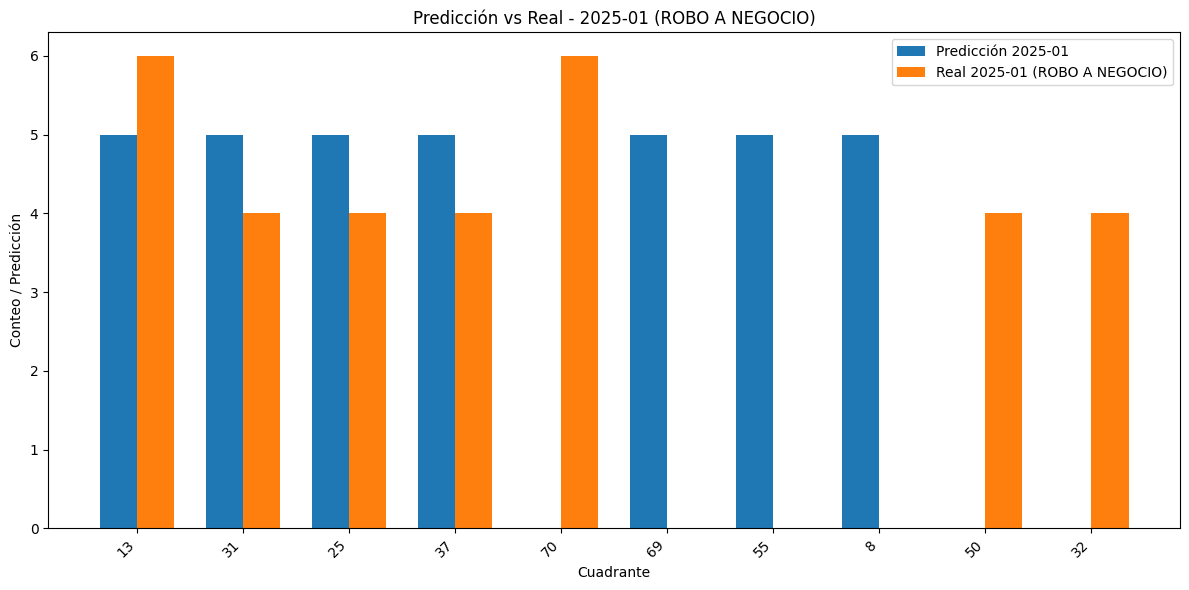

,CUADRANTE,PREDICCION_SUM,REAL_COUNT,TOTAL
0,13,5,6,11
1,31,5,4,9
2,25,5,4,9
3,37,5,4,9
4,70,0,6,6
5,69,5,0,5
6,55,5,0,5
7,8,5,0,5
8,50,0,4,4
9,32,0,4,4


In [33]:
# Comparación: Predicción (enero 2025) vs Real 2025 para 'ROBO A NEGOCIO'
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros: mes/año a comparar en formato 'YYYY-MM' y tipo objetivo
MES_OBJ = '2025-01'  # Mes que queremos comparar en la predicción
TIPO_OBJ = 'ROBO A NEGOCIO'

# Verificar existencia de los dataframes que contienen predicciones y datos reales
try:
    veinte25
except NameError:
    raise NameError('La variable veinte25 no está definida. Ejecuta la celda que carga el Excel antes.')

# Predicciones: intentamos usar 'df_forecast' (RandomForest) o 'df_results' (red neuronal)
pred_df = None
if 'df_forecast' in globals():
    pred_df = df_forecast.copy()
    # df_forecast usa FECHA en formato 'YYYY-MM'
    pred_df = pred_df[pred_df['FECHA'] == MES_OBJ] if 'FECHA' in pred_df.columns else pred_df
elif 'df_results' in globals():
    pred_df = df_results.copy()
    # df_results puede tener FECHA como datetime; filtramos por año/mes
    pred_df['year_month'] = pd.to_datetime(pred_df['FECHA']).dt.strftime('%Y-%m')
    pred_df = pred_df[pred_df['year_month'] == MES_OBJ]
else:
    raise NameError('No se encontró un DataFrame de predicción válido (se buscan df_forecast o df_results).')

# Construir Top-10 de la predicción: agrupar por CUADRANTE y sumar la predicción
if 'PREDICCION' in pred_df.columns:
    top_pred = pred_df.groupby('CUADRANTE')['PREDICCION'].sum().reset_index().rename(columns={'PREDICCION': 'PREDICCION_SUM'})
else:
    pred_col = [c for c in pred_df.columns if 'PREDICCION' in c.upper()][0]
    # intentar agrupar por 'CUADRANTE' o 'CUADRANTE_ID' según exista
    if 'CUADRANTE' in pred_df.columns:
        grp_col = 'CUADRANTE'
    else:
        grp_col = 'CUADRANTE_ID'
    top_pred = pred_df.groupby(grp_col)[pred_col].sum().reset_index().rename(columns={pred_col: 'PREDICCION_SUM', grp_col: 'CUADRANTE'})
top_pred = top_pred.sort_values('PREDICCION_SUM', ascending=False).head(10)
top_pred['PREDICCION_SUM'] = top_pred['PREDICCION_SUM'].round().astype(int)

# Construir Top-10 real para 2025 del tipo 'ROBO A NEGOCIO' (ej: enero 2025)
veinte25['year_month'] = pd.to_datetime(veinte25['FECHA']).dt.strftime('%Y-%m')
real_mes = veinte25[veinte25['year_month'] == MES_OBJ].copy()
if real_mes.empty:
    raise ValueError(f'No se encontraron registros reales para {MES_OBJ} en veinte25.')
top_real = real_mes[real_mes['TIPO'] == TIPO_OBJ].groupby('CUADRANTE').size().reset_index(name='REAL_COUNT').sort_values('REAL_COUNT', ascending=False).head(10)

# Unión de ambos Top-10 por CUADRANTE (outer) y relleno de ceros
df_top = pd.merge(top_pred, top_real, on='CUADRANTE', how='outer').fillna(0)
# Asegurar tipos enteros
if 'REAL_COUNT' in df_top.columns:
    df_top['REAL_COUNT'] = df_top['REAL_COUNT'].astype(int)
df_top['PREDICCION_SUM'] = df_top['PREDICCION_SUM'].astype(int)

# Ordenar por la suma para mostrar los cuadrantes más relevantes y limitar a 10
df_top['TOTAL'] = df_top['PREDICCION_SUM'] + df_top.get('REAL_COUNT', 0)
df_top = df_top.sort_values('TOTAL', ascending=False).head(10).reset_index(drop=True)

# Gráfica de barras agrupadas
labels = df_top['CUADRANTE'].astype(str).tolist()
pred_vals = df_top['PREDICCION_SUM'].tolist()
real_vals = df_top['REAL_COUNT'].tolist() if 'REAL_COUNT' in df_top.columns else [0]*len(labels)
x = range(len(labels))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar([p - width/2 for p in x], pred_vals, width=width, label=f'Predicción {MES_OBJ}')
plt.bar([p + width/2 for p in x], real_vals, width=width, label=f'Real {MES_OBJ} (ROBO A NEGOCIO)')
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel('Cuadrante')
plt.ylabel('Conteo / Predicción')
plt.title(f'Predicción vs Real - {MES_OBJ} (ROBO A NEGOCIO)')
plt.legend()
plt.tight_layout()
plt.show()

from IPython.display import display
display(df_top[['CUADRANTE', 'PREDICCION_SUM', 'REAL_COUNT', 'TOTAL']])

In [ ]:

# 4.2. Entrenamiento
print("\n--- COMENZANDO ENTRENAMIENTO DE LA RED NEURONAL ---")
history = model.fit(
    x=[X_cuadrante_train, X_num_train],
    y=Y_train,
    validation_data=([X_cuadrante_val, X_num_val], Y_val),
    epochs=50, 
    batch_size=32,
    verbose=1
)
print("✅ Entrenamiento del Modelo de Red Neuronal Finalizado.")


# --- 5. PREPARACIÓN Y PREDICCIÓN FINAL (Ejemplo para Enero 2024) ---

# Usamos el set de prueba para demostrar la predicción
X_cuadrante_test = df_test['CUADRANTE_ID'].values.astype(np.int32)
X_num_test = df_test[features].values.astype(np.float32)

# 5.1. Predicción en escala normalizada
y_pred_scaled = model.predict([X_cuadrante_test, X_num_test])

# 5.2. Desnormalizar la predicción
# Se crea un array 2D para inverse_transform
y_pred_denormalized = scaler_robos_total.inverse_transform(y_pred_scaled)

# 5.3. Formatear las 78 Salidas
df_results = pd.DataFrame({
    'CUADRANTE_ID': df_test['CUADRANTE_ID'].values,
    'FECHA': df_test['FECHA'].values,
    'PREDICCION_ROBOS_REAL': y_pred_denormalized.flatten()
})



In [ ]:
# Filtrar un mes específico y ordenar (ej: Enero 2024)
MES_A_EVALUAR = 1
prediccion_enero = df_results[df_results['FECHA'].dt.month == MES_A_EVALUAR].copy()
prediccion_enero['PREDICCION_ROBOS_REAL'] = prediccion_enero['PREDICCION_ROBOS_REAL'].round(0).astype(int)
prediccion_enero = prediccion_enero.sort_values(by='PREDICCION_ROBOS_REAL', ascending=False)


print(f"\n--- TOP 10 CUADRANTES CON MAYOR INCIDENCIA (Predicción para Enero 2024) ---")
print(prediccion_enero[['CUADRANTE_ID', 'PREDICCION_ROBOS_REAL']].head(10))

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Carga y Transformación de Formato Ancho a Largo ---

file_name = "cuadrantes_negocios.csv"
df_wide = pd.read_csv(file_name)


# Renombrar 'CUADRANTE' a 'CUADRANTE_ID' y 'POBLACION'
df_wide.rename(columns={'CUADRANTE': 'CUADRANTE_ID', 'POBLACION': 'POBLACION_BASE'}, inplace=True)

# Identificar las columnas de robos (todas las columnas excepto 'CUADRANTE_ID' y 'POBLACION_BASE')
id_vars = ['CUADRANTE_ID', 'POBLACION_BASE']
value_vars = [col for col in df_wide.columns if col not in id_vars]

# Transformación de Formato Ancho a Largo (Melting)
# Esto crea una fila por cada combinación de Cuadrante y Mes/Año
df_long = df_wide.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='MES_AÑO_STR', # Columna temporal que contiene el mes y el año
    value_name='ROBOS_TOTAL' # La variable objetivo
).copy()

# 1.1. Parsear la columna MES_AÑO_STR para crear la columna de FECHA
# Ejemplo: 'ROBOS A NEGOCIOS MES 1 2015' -> Enero 2015
def parse_date(date_str):
    # Separar la cadena por espacios
    parts = date_str.split(' ')
    mes = parts[4] # Ej: '1'
    año = parts[5] # Ej: '2015'
    return f'{año}-{mes}-01'

df_long['FECHA'] = df_long['MES_AÑO_STR'].apply(parse_date)
df_long['FECHA'] = pd.to_datetime(df_long['FECHA'])
df_long.sort_values(by=['CUADRANTE_ID', 'FECHA'], inplace=True)
df_long.drop(columns=['MES_AÑO_STR'], inplace=True)


# --- 2. Generación de Características Temporales ---

df_long['AÑO'] = df_long['FECHA'].dt.year
df_long['MES'] = df_long['FECHA'].dt.month
# df_long['DIA_DEL_MES'] = df_long['FECHA'].dt.day # Si fuera relevante, pero para mensual, el mes ya lo captura

# --- 3. Generación de Características Históricas (Retardos) ---

# Agrupar por CUADRANTE_ID para asegurar que el retardo sea solo dentro de esa serie de tiempo.
df_long['ROBOS_t-1'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(1)
df_long['ROBOS_t-12'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(12)

# Generación de la Media Móvil de 3 meses (excluyendo el mes actual)
# Usamos un Rolling Window de 3 periodos y lo shift(1) para aplicarlo al mes siguiente.
df_long['MEDIA_MOVIL_3M'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)


# --- 4. Limpieza Final para el Modelo ---

# Eliminar las filas que tienen valores NaN en los retardos (los primeros 12 meses de cada cuadrante)
# Estos no tienen suficiente historial para las variables t-12.
df_model_input = df_long.dropna(subset=['ROBOS_t-12']).copy()

# Seleccionar solo las columnas que servirán como entradas (X) y la salida (Y)
# NOTA: La POBLACION_BASE es estática. Otras variables como la violencia se añadirían aquí.
columnas_finales = [
    'CUADRANTE_ID',
    'FECHA',
    'AÑO',
    'MES',
    'POBLACION_BASE',
    'ROBOS_t-1',
    'ROBOS_t-12',
    'MEDIA_MOVIL_3M',
    'ROBOS_TOTAL' # Esta será la variable objetivo (Y)
]

df_model_input = df_model_input[columnas_finales]

print("--- Vista Preliminar de la Tabla de Entradas (Formato Largo) ---")
print(f"Total de filas generadas para el modelo: {len(df_model_input)}")
print("Ejemplo de las entradas para el CUADRANTE 1:")
print(df_model_input[df_model_input['CUADRANTE_ID'] == 1].head(15))

In [ ]:
# exportar df_model_input a un archivo csv
df_model_input.to_csv("ficosec_model_input.csv", index=False)

In [ ]:
# exportar df_model_input a un archivo xlsx
df_model_input.to_excel("ficosec_model_input.xlsx", index=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Suponiendo que 'df_model_input' es el DataFrame generado en el paso anterior

# 1. Identificar las columnas numéricas que necesitan escalado
features_to_scale = [
    'POBLACION_BASE',
    'ROBOS_t-1',
    'ROBOS_t-12',
    'MEDIA_MOVIL_3M',
    # La variable objetivo (Y) también debe escalarse
    'ROBOS_TOTAL' 
]

# 2. Inicializar el escalador
scaler = MinMaxScaler()

# 3. Aplicar el escalador a las columnas seleccionadas
df_model_input[features_to_scale] = scaler.fit_transform(df_model_input[features_to_scale])

# Guardar los escaladores si planeas desnormalizar las predicciones más tarde
# Por ejemplo, el scaler de ROBOS_TOTAL es crucial para llevar la predicción de vuelta a conteos reales.
scaler_robos_total = MinMaxScaler()
scaler_robos_total.fit(df_model_input[['ROBOS_TOTAL']]) # Se debe re-entrenar solo en el target si quieres desnormalizar fácilmente

print("✅ Normalización Min-Max aplicada a las variables numéricas.")
print(df_model_input[features_to_scale].head())

In [ ]:
# --- A. Codificación One-Hot para el MES ---

# Crear variables dummy para la columna 'MES'
df_processed = pd.get_dummies(df_model_input, columns=['MES'], prefix='MES')

# El CUADRANTE_ID se mantiene como está para el Embedding (se usará directamente en Keras/TensorFlow)

print("\n✅ Codificación One-Hot aplicada al MES.")
print(df_processed[[col for col in df_processed.columns if 'MES_' in col]].head())

In [ ]:
# 1. Definir las fechas de corte
FECHA_CORTE_VAL = pd.to_datetime('2023-01-01')
FECHA_CORTE_TEST = pd.to_datetime('2024-01-01')

# 2. Dividir los datos
df_train = df_processed[df_processed['FECHA'] < FECHA_CORTE_VAL].copy()
df_val = df_processed[(df_processed['FECHA'] >= FECHA_CORTE_VAL) & (df_processed['FECHA'] < FECHA_CORTE_TEST)].copy()
df_test = df_processed[df_processed['FECHA'] >= FECHA_CORTE_TEST].copy()

# 3. Definición de Entradas (X) y Salidas (Y)
features = [
    'POBLACION_BASE', 
    'ROBOS_t-1', 
    'ROBOS_t-12', 
    'MEDIA_MOVIL_3M'
] + [col for col in df_processed.columns if 'MES_' in col]

X_train = df_train[features]
Y_train = df_train['ROBOS_TOTAL']

X_val = df_val[features]
Y_val = df_val['ROBOS_TOTAL']

X_test = df_test[features]
Y_test = df_test['ROBOS_TOTAL']

# El CUADRANTE_ID se manejará como una entrada separada en el modelo de Keras/TensorFlow
train_cuadrante_id = df_train['CUADRANTE_ID']
val_cuadrante_id = df_val['CUADRANTE_ID']
test_cuadrante_id = df_test['CUADRANTE_ID']

print(f"\n✅ División de datos completada:")
print(f"  Entrenamiento (Train): {len(X_train)} filas")
print(f"  Validación (Validation): {len(X_val)} filas")
print(f"  Prueba (Test): {len(X_test)} filas")

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# --- CONSTANTES ---
NUM_CUADRANTES = df_model_input['CUADRANTE_ID'].nunique() # Debería ser 78
# La dimensión del embedding debe ser menor que el número de categorías. 
# Una regla empírica simple es tomar la raíz cuadrada del número de categorías.
EMBEDDING_DIM = int(np.sqrt(NUM_CUADRANTES)) # Ej: sqrt(78) ~ 8 o 9. Usemos 10.
EMBEDDING_DIM = 10
NUM_FEAT_NUMERICAS = X_train.shape[1] 

# --- CONVERSIÓN A ARRAYS DE NUMPY ---

# 1. Entradas para el Embedding (CUADRANTE_ID)
# Keras requiere que los IDs empiecen en 0 o 1. Usaremos 1 a N.
# NOTA: Los DataFrames 'train_cuadrante_id', 'val_cuadrante_id', 'test_cuadrante_id'
# ya están preparados para esto (valores de 1 a 78).
X_cuadrante_train = train_cuadrante_id.values
X_cuadrante_val = val_cuadrante_id.values
X_cuadrante_test = test_cuadrante_id.values

# 2. Entradas para las Características Numéricas (Robos t-1, Mes_1, etc.)
X_num_train = X_train.values
X_num_val = X_val.values
X_num_test = X_test.values

# 3. Salidas (Objetivo)
Y_train = Y_train.values
Y_val = Y_val.values
Y_test = Y_test.values

print(f"Número de Cuadrantes (Categorías): {NUM_CUADRANTES}")
print(f"Dimensión del Vector de Embedding: {EMBEDDING_DIM}")
print(f"Número de Características Numéricas/One-Hot: {NUM_FEAT_NUMERICAS}")

In [ ]:
# --- 1. Rama de Entrada para el CUADRANTE_ID (Embedding Layer) ---

# Input: Un array de números enteros (IDs de 1 a 78)
input_cuadrante = Input(shape=(1,), name='input_cuadrante')

# Embedding: Convierte cada ID de cuadrante en un vector denso (ej: 78x10)
# input_dim: Rango de los IDs (78 cuadrantes + 1 por convención)
# output_dim: La dimensión de nuestro vector de embedding (10)
embedding_layer = Embedding(
    input_dim=NUM_CUADRANTES + 1,
    output_dim=EMBEDDING_DIM,
    input_length=1,
    name='embedding_cuadrante'
)(input_cuadrante)

# Aplanar el Embedding (de (None, 1, 10) a (None, 10))
flatten_embedding = Flatten()(embedding_layer)


# --- 2. Rama de Entrada para las Características Numéricas ---

# Input: Un array con todas las características (Robos t-1, Mes_1, Población, etc.)
input_numerico = Input(shape=(NUM_FEAT_NUMERICAS,), name='input_numerico')


# --- 3. Combinación de Ramas (Merging) ---

# Concatenar el vector de embedding y las características numéricas
combined = Concatenate()([flatten_embedding, input_numerico])

# Capas Densa de la Red Neuronal (Deep Layers)
# Se utilizan capas profundas para aprender las interacciones complejas.
dense_1 = Dense(64, activation='relu')(combined)
dense_2 = Dense(32, activation='relu')(dense_1)

# Capa de Salida
# Output: Un único nodo que predice el valor escalado de ROBOS_TOTAL (Y).
output_layer = Dense(1, activation='linear', name='prediccion_final')(dense_2)


# --- 4. Crear el Modelo Final ---

model = Model(inputs=[input_cuadrante, input_numerico], outputs=output_layer)

# Compilación: Usamos 'mean_squared_error' (MSE) para regresión y Adam como optimizador.
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

In [ ]:
# --- CÓDIGO DE VERIFICACIÓN Y CORRECCIÓN DE TIPOS (Solución al ValueError) ---

# 1. Identificar todas las columnas que deberían ser numéricas (inputs y targets)
numerical_and_target_cols = [
    'POBLACION_BASE',
    'ROBOS_t-1',
    'ROBOS_t-12',
    'MEDIA_MOVIL_3M',
    'ROBOS_TOTAL'
]

# 2. Forzar la conversión de estas columnas a numérico (float)
# El argumento 'coerce' convierte cualquier valor no numérico (texto) a NaN.
for col in numerical_and_target_cols:
    df_model_input[col] = pd.to_numeric(df_model_input[col], errors='coerce')

# 3. Eliminar o Rellenar los valores NaN que se generaron
# Es más seguro eliminar las filas donde esto ocurre, aunque deberían ser pocas.
# Si el error ocurrió en una fila crítica (ej. ROBOS_TOTAL), la fila es inutilizable.
filas_antes = len(df_model_input)
df_model_input.dropna(subset=numerical_and_target_cols, inplace=True)
filas_despues = len(df_model_input)

if filas_antes != filas_despues:
    print(f"⚠️ Alerta: Se eliminaron {filas_antes - filas_despues} filas debido a valores no numéricos ocultos.")

# 4. Asegurar que las columnas de ID sean Enteros (para el Embedding)
# El Embedding Layer requiere IDs enteros.
df_model_input['CUADRANTE_ID'] = df_model_input['CUADRANTE_ID'].astype(np.int32)
df_model_input['MES'] = df_model_input['MES'].astype(np.int32) 

print("\n✅ Verificación de tipos de datos completada. Todos los inputs/outputs numéricos están limpios.")

In [ ]:
print(X_num_train.dtype)

In [ ]:
# convertir X_num_train a float32
X_num_train = X_num_train.astype(np.int32)
X_num_test = X_num_test.astype(np.int32)

In [ ]:
print(X_cuadrante_train.dtype)

In [ ]:
# convertir X_cuadrante_train a float64
X_cuadrante_train = X_cuadrante_train.astype(np.float64)
X_cuadrante_test = X_cuadrante_test.astype(np.float64)

In [ ]:
# Configuración del entrenamiento
history = model.fit(
    x=[X_cuadrante_train, X_num_train],
    y=Y_train,
    validation_data=([X_cuadrante_val, X_num_val], Y_val),
    epochs=50, # Puedes empezar con 50 o 100 épocas
    batch_size=32,
    verbose=1
)

print("\n✅ Entrenamiento del Modelo de Red Neuronal Finalizado.")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.losses import Poisson
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURACIÓN Y CONSTANTES ---
# Asegúrate de que este sea el nombre de tu archivo
FILE_NAME = "cuadrantes_negocios.csv" 
NUM_CUADRANTES = 78
EMBEDDING_DIM = 10 
EPOCHS = 100
BATCH_SIZE = 16

# --- 1. CARGA, TRANSFORMACIÓN (ANCHO A LARGO) Y GENERACIÓN DE FEATURES ---

def load_and_prepare_data(file_name):
    """Carga, transforma el formato ancho a largo y genera features de retardo."""
    try:
        df_wide = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{file_name}'.")
        raise

    df_wide.rename(columns={'CUADRANTE': 'CUADRANTE_ID', 'POBLACION': 'POBLACION_BASE'}, inplace=True)
    
    id_vars = ['CUADRANTE_ID', 'POBLACION_BASE']
    value_vars = [col for col in df_wide.columns if col not in id_vars]

    # Transformación de Ancho a Largo (Melt)
    df_long = df_wide.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='MES_AÑO_STR',
        value_name='ROBOS_TOTAL'
    ).copy()

    # Parsear la fecha
    def parse_date(date_str):
        parts = date_str.split(' ')
        # Asumiendo el formato 'ROBOS A NEGOCIOS MES 1 2015'
        mes = parts[4] 
        año = parts[5] 
        return f'{año}-{mes}-01'

    df_long['FECHA'] = df_long['MES_AÑO_STR'].apply(parse_date)
    df_long['FECHA'] = pd.to_datetime(df_long['FECHA'])
    df_long.sort_values(by=['CUADRANTE_ID', 'FECHA'], inplace=True)
    df_long.drop(columns=['MES_AÑO_STR'], inplace=True)

    # Generación de Características Temporales y Retardos
    df_long['AÑO'] = df_long['FECHA'].dt.year
    df_long['MES'] = df_long['FECHA'].dt.month
    df_long['ROBOS_t-1'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(1)
    df_long['ROBOS_t-12'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(12)
    df_long['MEDIA_MOVIL_3M'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)
    
    # Eliminar filas con NaN en los retardos (primeros 12 meses)
    df_model_input = df_long.dropna(subset=['ROBOS_t-12']).copy()
    
    return df_model_input

# Cargar y preparar los datos
df_model_input = load_and_prepare_data(FILE_NAME)


# --- 2. LIMPIEZA, NORMALIZACIÓN (SOLO FEATURES) Y CODIFICACIÓN ---

# 2.1. Verificación y Corrección de Tipos (Limpieza de "object")
numerical_and_target_cols = ['POBLACION_BASE', 'ROBOS_t-1', 'ROBOS_t-12', 'MEDIA_MOVIL_3M', 'ROBOS_TOTAL']
for col in numerical_and_target_cols:
    df_model_input[col] = pd.to_numeric(df_model_input[col], errors='coerce')

df_model_input.dropna(subset=numerical_and_target_cols, inplace=True)
df_model_input['CUADRANTE_ID'] = df_model_input['CUADRANTE_ID'].astype(np.int32)
df_model_input['MES'] = df_model_input['MES'].astype(np.int32)

# 2.2. Normalización Min-Max (¡SOLO VARIABLES DE ENTRADA/FEATURES!)
scaler = MinMaxScaler()
features_to_scale = ['POBLACION_BASE', 'ROBOS_t-1', 'ROBOS_t-12', 'MEDIA_MOVIL_3M']

# El target 'ROBOS_TOTAL' NO se normaliza para la Pérdida de Poisson.
df_model_input[features_to_scale] = scaler.fit_transform(df_model_input[features_to_scale])

# 2.3. Codificación One-Hot para el MES
df_processed = pd.get_dummies(df_model_input, columns=['MES'], prefix='MES')


# --- 3. DIVISIÓN DE DATOS Y PREPARACIÓN DE ARRAYS ---

FECHA_CORTE_VAL = pd.to_datetime('2023-01-01')
FECHA_CORTE_TEST = pd.to_datetime('2024-01-01')

# División
df_train = df_processed[df_processed['FECHA'] < FECHA_CORTE_VAL]
df_val = df_processed[(df_processed['FECHA'] >= FECHA_CORTE_VAL) & (df_processed['FECHA'] < FECHA_CORTE_TEST)]
df_test = df_processed[df_processed['FECHA'] >= FECHA_CORTE_TEST]

# Definición de Features para la rama numérica
features = features_to_scale + [col for col in df_processed.columns if 'MES_' in col]


# Conversión a Arrays de NumPy con tipo explícito
X_cuadrante_train = df_train['CUADRANTE_ID'].values.astype(np.int32)
X_cuadrante_val = df_val['CUADRANTE_ID'].values.astype(np.int32)
X_cuadrante_test = df_test['CUADRANTE_ID'].values.astype(np.int32)

X_num_train = df_train[features].values.astype(np.float32)
X_num_val = df_val[features].values.astype(np.float32)
X_num_test = df_test[features].values.astype(np.float32)

# Y_train usa el valor de conteo original (CORRECCIÓN CRÍTICA)
Y_train = df_train['ROBOS_TOTAL'].values.astype(np.float32)
Y_val = df_val['ROBOS_TOTAL'].values.astype(np.float32)
Y_test = df_test['ROBOS_TOTAL'].values.astype(np.float32)


# --- 4. CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO DE RED NEURONAL ---

def build_model(num_cuadrantes, embedding_dim, num_feat_numericas):
    
    # 1. Rama Embedding
    input_cuadrante = Input(shape=(1,), name='input_cuadrante')
    embedding_layer = Embedding(
        input_dim=num_cuadrantes + 1, 
        output_dim=embedding_dim,
        input_length=1,
        name='embedding_cuadrante'
    )(input_cuadrante)
    flatten_embedding = Flatten()(embedding_layer)

    # 2. Rama Numérica
    input_numerico = Input(shape=(num_feat_numericas,), name='input_numerico')

    # 3. Concatenación y Capas Profundas (AUMENTADAS)
    combined = Concatenate()([flatten_embedding, input_numerico])
    
    # Capas Ocultas con mayor capacidad
    dense_1 = Dense(128, activation='relu')(combined) 
    dense_2 = Dense(64, activation='relu')(dense_1)   
    dense_3 = Dense(32, activation='relu')(dense_2)   
    
    # 4. Capa de Salida: SOFTPLUS para asegurar predicciones NO NEGATIVAS.
    output_layer = Dense(1, activation='softplus', name='prediccion_final')(dense_3)

    model = Model(inputs=[input_cuadrante, input_numerico], outputs=output_layer)
    
    # Compilación: LOSS POISSON para datos de conteo.
    model.compile(optimizer='adam', loss=Poisson(), metrics=['mae'])
    
    return model

model = build_model(NUM_CUADRANTES, EMBEDDING_DIM, X_num_train.shape[1])

# 4.2. Entrenamiento
print("\n--- COMENZANDO ENTRENAMIENTO (Poisson Loss) ---")
print("El modelo ahora entrena con valores de conteo originales.")

history = model.fit(
    x=[X_cuadrante_train, X_num_train],
    y=Y_train,
    validation_data=([X_cuadrante_val, X_num_val], Y_val),
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1
)
print("✅ Entrenamiento del Modelo de Red Neuronal Finalizado.")


# --- 5. PREDICCIÓN FINAL (Ejemplo para Enero 2024) ---

# 5.1. Predicción: El resultado ya está en la escala de conteo real.
y_pred_real = model.predict([X_cuadrante_test, X_num_test])

# 5.2. Formatear las 78 Salidas
df_results = pd.DataFrame({
    'CUADRANTE_ID': df_test['CUADRANTE_ID'].values,
    'FECHA': df_test['FECHA'].values,
    # La predicción ya es el conteo real, solo se redondea.
    'PREDICCION_ROBOS_REAL': y_pred_real.flatten()
})

In [ ]:
# Filtrar un mes específico y ordenar (ej: Enero 2024)
MES_A_EVALUAR = 1
prediccion_enero = df_results[df_results['FECHA'].dt.month == MES_A_EVALUAR].copy()
prediccion_enero['PREDICCION_ROBOS_REAL'] = prediccion_enero['PREDICCION_ROBOS_REAL'].round(0).astype(int)
prediccion_enero = prediccion_enero.sort_values(by='PREDICCION_ROBOS_REAL', ascending=False)


print(f"\n--- TOP 10 CUADRANTES CON MAYOR INCIDENCIA (Predicción para Enero 2024) ---")
print(prediccion_enero[['CUADRANTE_ID', 'PREDICCION_ROBOS_REAL']].head(10))

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Preparación de los datos reales (Y_test) ---

# Aseguramos que Y_test use el valor de conteo original.
# Nota: Y_test se definió como df_test['ROBOS_TOTAL'].values.astype(np.float32)
# Esto se hizo antes del entrenamiento, por lo que ya contiene los valores REALES.

# Creamos una columna con los valores reales del conjunto de prueba.
df_test['ROBOS_REAL'] = Y_test 


# --- 2. Formato de la Tabla de Resultados ---

# df_results fue generado en el paso anterior y contiene:
# ['CUADRANTE_ID', 'FECHA', 'PREDICCION_ROBOS_REAL']

# Unimos los resultados de la predicción con los valores reales
df_comparacion = df_results.merge(
    df_test[['CUADRANTE_ID', 'FECHA', 'ROBOS_REAL']], 
    on=['CUADRANTE_ID', 'FECHA'], 
    how='left'
).copy()

# Redondear y asegurar que los conteos sean enteros
df_comparacion['PREDICCION_ROBOS_REAL'] = df_comparacion['PREDICCION_ROBOS_REAL'].round(0).astype(int)
df_comparacion['ROBOS_REAL'] = df_comparacion['ROBOS_REAL'].round(0).astype(int)

# --- 3. Filtrar para Enero de 2024 y Mostrar ---

MES_A_EVALUAR = 1
AÑO_A_EVALUAR = 2024

df_enero_2024 = df_comparacion[
    (df_comparacion['FECHA'].dt.month == MES_A_EVALUAR) & 
    (df_comparacion['FECHA'].dt.year == AÑO_A_EVALUAR)
].sort_values(by='PREDICCION_ROBOS_REAL', ascending=False).reset_index(drop=True)

# Añadir la diferencia (Error)
df_enero_2024['ERROR (Real - Pred)'] = df_enero_2024['ROBOS_REAL'] - df_enero_2024['PREDICCION_ROBOS_REAL']

# Seleccionar y mostrar las columnas clave
df_final = df_enero_2024[['CUADRANTE_ID', 'ROBOS_REAL', 'PREDICCION_ROBOS_REAL', 'ERROR (Real - Pred)']]

print(f"\n--- Comparación de Robos a Negocio: {MES_A_EVALUAR}/{AÑO_A_EVALUAR} ---")
print("Ordenado por la Predicción (Mayor Riesgo)")

# 

print(df_final.head(20).to_markdown(index=False))

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

# --- 1. Obtener las predicciones del modelo ---
# Nota: Asumimos que X_cuadrante_test y X_num_test ya están definidos y listos.

# Predicción en escala de conteo (no normalizada)
y_pred_real = model.predict([X_cuadrante_test, X_num_test])

# --- 2. Preparar los datos para R2 ---

# Y_test es el valor real (conteo, float32)
# y_pred_real es el valor predicho (conteo, float32)

# Scikit-learn espera arrays 1D. Aplanamos las predicciones.
y_true = Y_test 
y_predicted = y_pred_real.flatten()

# Opcional: Redondear a entero para el R2, ya que son conteos (aunque no es estrictamente necesario)
# Usaremos el valor flotante para mayor precisión en la métrica:

# --- 3. Calcular el R^2 ---

# La función r2_score maneja el cálculo R^2
r2 = r2_score(y_true, y_predicted)

# --- 4. Mostrar el Resultado ---

print("\n--- Evaluación del Modelo de Red Neuronal ---")
print(f"Número total de predicciones evaluadas: {len(y_true)}")
print(f"El Coeficiente de Determinación (R^2) en el conjunto de prueba es: {r2:.4f}")

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten, LSTM, Dropout
from tensorflow.keras.losses import Poisson
import warnings
warnings.filterwarnings('ignore') # Ocultar advertencias

# --- CONFIGURACIÓN Y CONSTANTES ---
FILE_NAME = "cuadrantes_negocios.csv"
NUM_CUADRANTES = 78
EMBEDDING_DIM = 10 
EPOCHS = 100
BATCH_SIZE = 16
TIME_STEPS = 3 # Ventana de tiempo (3 meses anteriores)

# --- 1. CARGA, TRANSFORMACIÓN (ANCHO A LARGO) Y GENERACIÓN DE FEATURES ---

def load_and_prepare_data(file_name):
    """Carga, transforma el formato ancho a largo y genera features de retardo."""
    try:
        df_wide = pd.read_csv(file_name)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{file_name}'.")
        raise

    df_wide.rename(columns={'CUADRANTE': 'CUADRANTE_ID', 'POBLACION': 'POBLACION_BASE'}, inplace=True)
    
    id_vars = ['CUADRANTE_ID', 'POBLACION_BASE']
    value_vars = [col for col in df_wide.columns if col not in id_vars]

    df_long = df_wide.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='MES_AÑO_STR',
        value_name='ROBOS_TOTAL'
    ).copy()

    def parse_date(date_str):
        parts = date_str.split(' ')
        mes = parts[4] 
        año = parts[5] 
        return f'{año}-{mes}-01'

    df_long['FECHA'] = df_long['MES_AÑO_STR'].apply(parse_date)
    df_long['FECHA'] = pd.to_datetime(df_long['FECHA'])
    df_long.sort_values(by=['CUADRANTE_ID', 'FECHA'], inplace=True)
    df_long.drop(columns=['MES_AÑO_STR'], inplace=True)

    df_long['AÑO'] = df_long['FECHA'].dt.year
    df_long['MES'] = df_long['FECHA'].dt.month
    df_long['ROBOS_t-1'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(1)
    df_long['ROBOS_t-12'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].shift(12)
    df_long['MEDIA_MOVIL_3M'] = df_long.groupby('CUADRANTE_ID')['ROBOS_TOTAL'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)
    
    df_model_input = df_long.dropna(subset=['ROBOS_t-12']).copy()
    
    return df_model_input

df_model_input = load_and_prepare_data(FILE_NAME)


# --- 2. LIMPIEZA, NORMALIZACIÓN (SOLO FEATURES) Y CODIFICACIÓN ---

numerical_and_target_cols = ['POBLACION_BASE', 'ROBOS_t-1', 'ROBOS_t-12', 'MEDIA_MOVIL_3M', 'ROBOS_TOTAL']
for col in numerical_and_target_cols:
    df_model_input[col] = pd.to_numeric(df_model_input[col], errors='coerce')

df_model_input.dropna(subset=numerical_and_target_cols, inplace=True)
df_model_input['CUADRANTE_ID'] = df_model_input['CUADRANTE_ID'].astype(np.int32)
df_model_input['MES'] = df_model_input['MES'].astype(np.int32)

# 2.2. Normalización Min-Max (SOLO FEATURES)
scaler = MinMaxScaler()
features_to_scale = ['POBLACION_BASE', 'ROBOS_t-1', 'ROBOS_t-12', 'MEDIA_MOVIL_3M']
df_model_input[features_to_scale] = scaler.fit_transform(df_model_input[features_to_scale])

# 2.3. Codificación One-Hot para el MES
df_processed = pd.get_dummies(df_model_input, columns=['MES'], prefix='MES')


# --- 3. DIVISIÓN DE DATOS Y PREPARACIÓN DE ARRAYS SEQUENCIALES ---

FECHA_CORTE_VAL = pd.to_datetime('2023-01-01')
FECHA_CORTE_TEST = pd.to_datetime('2024-01-01')

df_train = df_processed[df_processed['FECHA'] < FECHA_CORTE_VAL]
df_val = df_processed[(df_processed['FECHA'] >= FECHA_CORTE_VAL) & (df_processed['FECHA'] < FECHA_CORTE_TEST)]
df_test = df_processed[df_processed['FECHA'] >= FECHA_CORTE_TEST]

# Definición de Features para la LSTM
features_lstm = [col for col in df_processed.columns if col not in ['CUADRANTE_ID', 'FECHA', 'ROBOS_TOTAL', 'AÑO']]


def create_sequences(df, Y_values, time_steps):
    """Transforma datos tabulares en secuencias (Timesteps, Features) para LSTM."""
    Xs, Ys, Cuadrantes = [], [], []
    
    for id in df['CUADRANTE_ID'].unique():
        df_cuadrante = df[df['CUADRANTE_ID'] == id].copy().reset_index(drop=True)
        
        # Iteramos a través de la serie del tiempo para crear la ventana
        for i in range(len(df_cuadrante) - time_steps):
            
            # X_seq: Los 'time_steps' (3) meses anteriores para las features
            X_seq = df_cuadrante.loc[i:(i + time_steps - 1), features_lstm].values
            
            # Y_val: El valor a predecir (ROBOS_TOTAL) justo después de la ventana
            # Usamos el índice de df_cuadrante para obtener el valor real del target (Y)
            Y_val = df_cuadrante.loc[i + time_steps, 'ROBOS_TOTAL']
            
            # Cuadrante ID para el Embedding
            Cuadrante_ID_val = df_cuadrante.loc[i + time_steps, 'CUADRANTE_ID']
            
            Xs.append(X_seq)
            Ys.append(Y_val)
            Cuadrantes.append(Cuadrante_ID_val)

    # Conversión a arrays de NumPy con el tipo correcto
    return np.array(Xs, dtype=np.float32), np.array(Ys, dtype=np.float32), np.array(Cuadrantes, dtype=np.int32)


# Generar las nuevas entradas secuenciales
X_train_seq, Y_train_seq, X_cuadrante_train_seq = create_sequences(df_train, df_train['ROBOS_TOTAL'], TIME_STEPS)
X_val_seq, Y_val_seq, X_cuadrante_val_seq = create_sequences(df_val, df_val['ROBOS_TOTAL'], TIME_STEPS)
X_test_seq, Y_test_seq, X_cuadrante_test_seq = create_sequences(df_test, df_test['ROBOS_TOTAL'], TIME_STEPS)

# --- MODIFICACIÓN EN EL PASO 4 (build_lstm_model) ---
# [Solo mostraré la función build_lstm_model modificada]

def build_lstm_model(num_cuadrantes, embedding_dim, seq_length, num_features):
    
    # 1. Rama Embedding (CUADRANTE_ID)
    input_cuadrante = Input(shape=(1,), name='input_cuadrante')
    embedding_layer = Embedding(
        input_dim=num_cuadrantes + 1, 
        output_dim=embedding_dim,
        input_length=1,
        name='embedding_cuadrante'
    )(input_cuadrante)
    flatten_embedding = Flatten()(embedding_layer)

    # 2. Rama Secuencial (LSTM)
    input_sequence = Input(shape=(seq_length, num_features), name='input_sequence')
    
    # Capa LSTM 1: Aumentamos unidades y añadimos return_sequences=True
    lstm_out = LSTM(128, activation='tanh', return_sequences=True)(input_sequence) 
    lstm_out = Dropout(0.3)(lstm_out) # Aumentamos Dropout

    # Capa LSTM 2: Añadimos una segunda capa LSTM para profundidad
    lstm_out = LSTM(64, activation='tanh', return_sequences=False)(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)

    # 3. Concatenación y Capas Profundas
    combined = Concatenate()([flatten_embedding, lstm_out])
    
    # Capas Densa Finales (Aumentamos unidades)
    dense_1 = Dense(128, activation='relu')(combined)
    dense_2 = Dense(64, activation='relu')(dense_1)
    
    # 4. Capa de Salida: Softplus y Poisson Loss
    output_layer = Dense(1, activation='softplus', name='prediccion_final')(dense_2)

    model = Model(inputs=[input_cuadrante, input_sequence], outputs=output_layer)
    model.compile(optimizer='adam', loss=Poisson(), metrics=['mae'])
    
    return model


# --- 5. EVALUACIÓN Y CÁLCULO FINAL DEL R^2 ---

# 5.1. Predicción en escala de conteo (no normalizada)
y_pred_real_lstm = model.predict([X_cuadrante_test_seq, X_test_seq])

# 5.2. Calcular el R^2
r2_lstm = r2_score(Y_test_seq, y_pred_real_lstm.flatten())

print("\n--- 📈 EVALUACIÓN DEL MODELO LSTM ---")
print(f"El Coeficiente de Determinación (R^2) en el conjunto de prueba es: {r2_lstm:.4f}")

# --- 6. VISUALIZACIÓN DE LA COMPARACIÓN ---

# Crear DataFrame para el R^2
df_test_filtered = df_test.iloc[TIME_STEPS:].copy().reset_index(drop=True)

df_results = pd.DataFrame({
    'CUADRANTE_ID': X_cuadrante_test_seq,
    'FECHA': df_test_filtered['FECHA'].values,
    'ROBOS_REAL': Y_test_seq,
    'PREDICCION_ROBOS_REAL': y_pred_real_lstm.flatten()
})

# Filtrar para Enero 2024
MES_A_EVALUAR = 1
df_enero_2024 = df_results[
    (df_results['FECHA'].dt.month == MES_A_EVALUAR) & 
    (df_results['FECHA'].dt.year == 2024)
].copy()

df_enero_2024['PREDICCION_ROBOS_REAL'] = df_enero_2024['PREDICCION_ROBOS_REAL'].round(0).astype(int)
df_enero_2024['ROBOS_REAL'] = df_enero_2024['ROBOS_REAL'].round(0).astype(int)
df_enero_2024['ERROR (Real - Pred)'] = df_enero_2024['ROBOS_REAL'] - df_enero_2024['PREDICCION_ROBOS_REAL']
df_enero_2024 = df_enero_2024.sort_values(by='PREDICCION_ROBOS_REAL', ascending=False)

df_final = df_enero_2024[['CUADRANTE_ID', 'ROBOS_REAL', 'PREDICCION_ROBOS_REAL', 'ERROR (Real - Pred)']]

print(f"\n--- Comparación Enero 2024 (Ordenado por Predicción) ---")
print(df_final.head(20).to_markdown(index=False))